<H1>Predicting Recipe Ratings with SVMs</H1><br>

This project uses data on over 20,000 <a href='https://www.epicurious.com/'>Epicurious</a> recipes from <a href='https://www.kaggle.com/hugodarwood/epirecipes'>Kaggle's open datasets.</a>

My goal is to make predictions about recipe ratings using a support vector machine (SVM) classification model.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from recipe_categories import get_categories
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import datetime
%matplotlib inline

The distribution of ratings has some peculiarities.

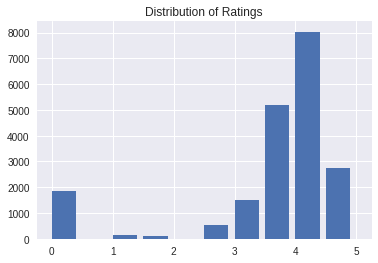

In [2]:
raw_data = pd.read_json('full_format_recipes.json').dropna(thresh=2)  #Dropping some null rows
raw_data = raw_data[raw_data.rating.notnull()]  #Drop rows with null ratings

raw_data.rating.hist(width=.4);
plt.title('Distribution of Ratings');

While many distributions are grouped around the value of four, there are a large number of ratings of zero. <br>
<H2>Research Questions</H2><br>
I'd like to address two questions:

1. What's going on with the zero ratings? Can we predict them?
2. Can we predict whether recipes have ratings above or below four?

In [3]:
#Define Outcome Variables
raw_data['four_plus'] = np.where(raw_data.rating>4, 1, 0)
raw_data['no_rating'] = np.where(raw_data.rating==0, 1, 0)

<H2>Question 1: What's with the zero ratings?</H2><br>
The number of zero ratings is odd, considering there are few recipes with very low ratings. A quick look at the Epicurious site shows that it's actually impossible to give a zero rating; the minimum rating is "one fork." Maybe the zero recipes are simply new recipes that haven't yet recieved any ratings.<br><br>
I'll take a look at the evolution of ratings over time and see if this story makes sense.

In [4]:
latest_date = raw_data.date.max()
raw_data['t_delta'] = latest_date-raw_data.date
raw_data['years_old'] = raw_data.t_delta.apply(lambda x: int(x.days/365))
raw_data['age'] = raw_data.years_old/raw_data.years_old.max()

#Drop the 13 recipes with strange dates, like 20+ years old recipes.
raw_data = raw_data[raw_data.years_old <= 12]

raw_data['half_years'] = raw_data.t_delta.apply(lambda x: int(x.days/182))

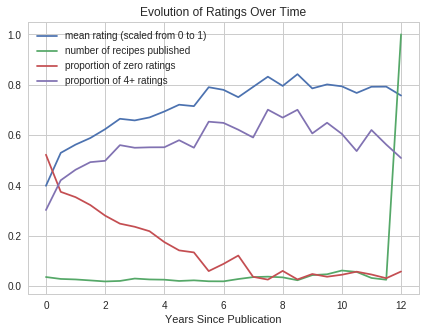

In [5]:
hyrs = pd.Series(raw_data.half_years.unique()).sort_values()
mean_rating = []
four_plus = []
n_recipes = []
zeros = []
for hy in hyrs:
    df = raw_data[raw_data.half_years == hy]
    mean_rating.append(df.rating.mean())
    four_plus.append(df.four_plus.sum())
    zeros.append(df.no_rating.sum())
    n_recipes.append(len(df))
    
n_recipes = pd.Series(n_recipes)
perc_zeros = zeros/n_recipes
four_plus = four_plus/n_recipes
n_recipes = n_recipes/n_recipes.max()
mean_rating = np.array(mean_rating)/5

    
sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5));
years = np.array(hyrs)/2
plt.plot(years, mean_rating, label='mean rating (scaled from 0 to 1)');
plt.plot(years, n_recipes, label='number of recipes published');
plt.plot(years, perc_zeros, label='proportion of zero ratings');
plt.plot(years, four_plus, label='proportion of 4+ ratings');
plt.title('Evolution of Ratings Over Time');
plt.xlabel('Years Since Publication');
plt.legend(loc=2);

The red line in this plot represents the number of zero ratings as a proportion of the total number of recipes. We can see the maximum number of zero ratings occurs for the newest recipes, and it consistently decreases over time. This seems to consistent with the idea that these recipes have not yet been rated by Epicurious visitors.<br>

Another interesting feature is the high number of recipes published at the "12 years ago" mark. This may indicate that the publication date information from recipes before that point is inaccurate, or that this is the default date for recipes whose publication dates are not recorded in this dataset.<br>

<H3>Building Features</H3><br>
There are several interesting things to look at. Before looking at any categorical information about the recipes, let's define recipes by length. We can use the number of ingredients and the number of words in the directions to do this.<br>
Some recipes have descriptions attached to them, while other don't. Let's flag the described recipes and see if that makes a difference.

In [6]:
def get_full_dir(lst):
    """consolidates directions from list to single string"""
    doc = ''
    for step in lst:
        doc += step + ' '
    return doc

#Build features...
#Length of ingredients list
raw_data['n_ingredients'] = raw_data.ingredients.apply(len)

#Consolodate directions into single string and get number of words
raw_data['dir_doc'] = raw_data.directions.apply(get_full_dir)
raw_data['n_words'] = raw_data.dir_doc.apply(lambda x: len(x.split()))
raw_data['binned_length'] = np.where(raw_data.n_words <= 50, 1, False)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words <= 100, 2, False), raw_data.binned_length)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words <= 150, 3, False), raw_data.binned_length)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words <= 200, 4, False), raw_data.binned_length)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words <= 300, 5, False), raw_data.binned_length)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words <= 500, 6, False), raw_data.binned_length)
raw_data.binned_length = np.where(raw_data.binned_length == False, np.where(raw_data.n_words > 500, 7, False), raw_data.binned_length)
raw_data['nw_scaled'] = raw_data.n_words/raw_data.n_words.max()
bin_desc = {
    # Maps bin values to length of directions
    1 : '< 50',
    2 : '50-100',
    3 : '100-150',
    4 : '150-200',
    5 : '200-300',
    6 : '300-500',
    7 : '> 500'
}

#Flag whether the recipe has a description
raw_data['has_desc'] = np.where(raw_data.desc, 1, 0)

#Drop the 22 recipes with more than 30 ingredients
raw_data = raw_data[raw_data['n_ingredients'] <= 30]

Let's see if these features give us any additional information about zero ratings.

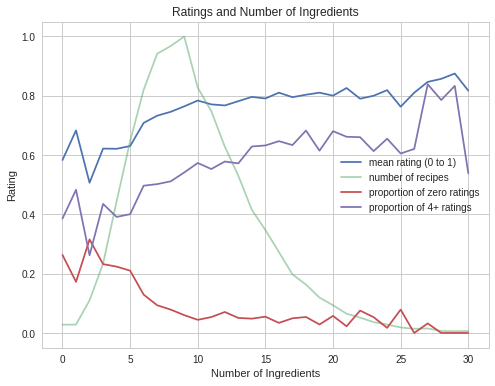

In [7]:
lengths = pd.Series(raw_data.n_ingredients.unique()).sort_values()
mean_rating = []
rating_std = []
n_recipes = []
four_plus = []
zeros = []

for l in lengths:
    df = raw_data[raw_data.n_ingredients == l]
    four_plus.append(df.four_plus.sum())
    zeros.append(df.no_rating.sum())
    mean_rating.append(df.rating.mean())
    rating_std.append(df.rating.std())
    n_recipes.append(len(df))
    
n_recipes = pd.Series(n_recipes)
four_plus = four_plus/n_recipes
perc_zeros = zeros/n_recipes
n_recipes = n_recipes/n_recipes.max()
mean_rating = np.array(mean_rating)/5
    
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
plt.plot(lengths, mean_rating, label='mean rating (0 to 1)');
plt.plot(lengths, n_recipes, label='number of recipes', alpha=.5);
plt.plot(lengths, perc_zeros, label='proportion of zero ratings');
plt.plot(lengths, four_plus, label='proportion of 4+ ratings');
plt.title('Ratings and Number of Ingredients');
plt.xlabel('Number of Ingredients');
plt.ylabel('Rating');
plt.legend(loc=5);

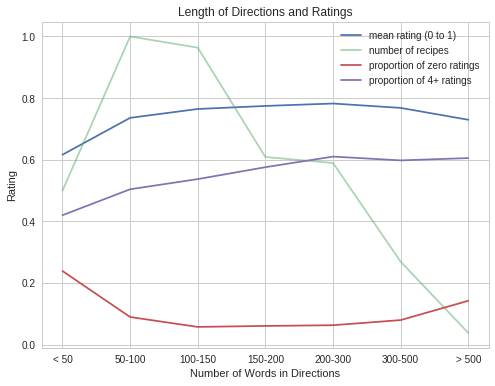

In [8]:
word_bins = pd.Series(raw_data.binned_length.unique()).sort_values()
mean_rating = []
rating_std = []
n_recipes = []
zeros = []
four_plus = []

for w in word_bins:
    df = raw_data[raw_data.binned_length == w]
    zeros.append(df.no_rating.sum())
    four_plus.append(df.four_plus.sum())
    mean_rating.append(df.rating.mean())
    rating_std.append(df.rating.std())
    n_recipes.append(len(df))
    
n_recipes = pd.Series(n_recipes)
four_plus = four_plus/n_recipes
perc_zeros = zeros/n_recipes
n_recipes = n_recipes/n_recipes.max()
mean_rating = np.array(mean_rating)/5
    
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
plt.plot(word_bins, mean_rating, label='mean rating (0 to 1)');
plt.plot(word_bins, n_recipes, label='number of recipes', alpha=.5);
plt.plot(word_bins, perc_zeros, label='proportion of zero ratings');
plt.plot(word_bins, four_plus, label='proportion of 4+ ratings');
plt.title('Length of Directions and Ratings');
plt.xlabel('Number of Words in Directions');
plt.ylabel('Rating');
plt.xticks(range(1,8), [bin_desc[i] for i in range(1, 8)]);
plt.legend(loc=0);

It looks like short recipes with few ingredients tend to have more zero ratings. What types of recipes are short and have 5 or less ingredients? Think about it...<br><br>
Cocktails and drinks! Is it possible that cocktail and drink recipes take longer to recieve ratings than food recipes? This would make sense, since Epicurious appears to market itself as a food recipe hub over being a mixology site. Let's see if there's any evidence in the data to support this story.<br><br>
<H3>Categorizing Recipes</H3><br>
Every recipe in this data set comes with a list of categories. The words in these lists vary: there are specific ingredients, geographic features (cities, states, countries), meals, events and holidays, kosher recipes, and other miscellaneous things. In total, there are over 600 unique categories.<br><br>
We might expect event and holiday-related recipes to recieve ratings faster than other categories, since they are posted around holidays and are likely used and rated around the same time. If true, this could help us with our predictions later on.<br><br>
In a couple of hours, I was able to split these categories into roughly 30 "meta-categories." I wrote <a href>a script</a> to group each recipe into each of these meta-categories, which can help us differentiate cocktail and drink recipes from food recipes, etc.

In [9]:
raw_data['meta_categories'] = raw_data.categories.apply(get_categories)

def match_cat(recipe_cats, cat):
    """Takes a list of categories from a recipe and a single string,
    checks to see if string in list, if yes, returns 1, else 0.
    """
    if cat in recipe_cats:
        return 1
    return 0

meta_cats = get_categories('get_keys')
meta_cat_features = []
for cat in meta_cats:
    feature = cat + '_meta'
    meta_cat_features.append(feature)
    raw_data[feature] = raw_data.meta_categories.apply(lambda x: match_cat(x, cat))

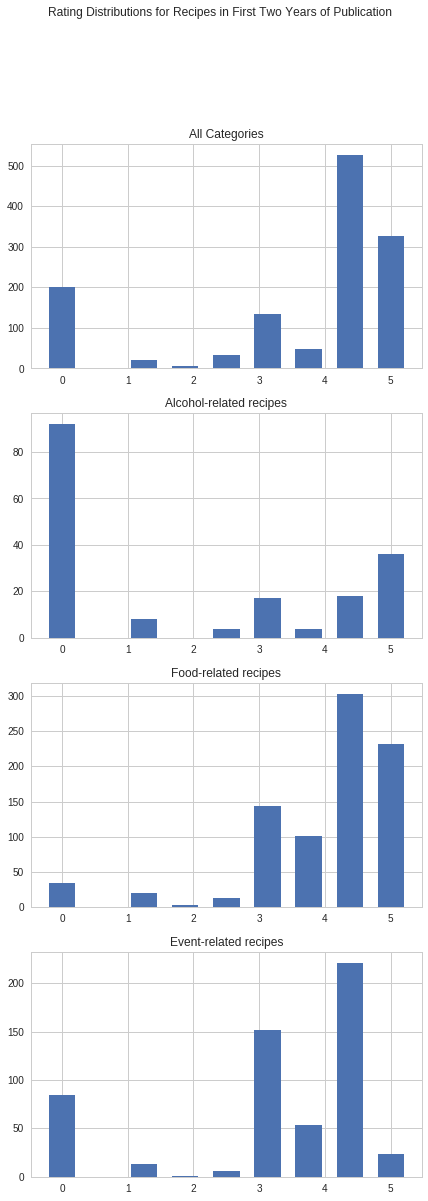

In [10]:
yr1 = raw_data[raw_data.years_old < 2]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(7, 19));
fig.suptitle('Rating Distributions for Recipes in First Two Years of Publication');
ax1.bar(yr1.rating.unique(), yr1.rating.value_counts(), width=.4);
ax1.set_title('All Categories');
df = yr1[yr1['alcohol_meta'] == 1]
ax2.bar(df.rating.unique(), df.rating.value_counts(), width=.4);
ax2.set_title('Alcohol-related recipes');
df = yr1[yr1['events_meta'] == 1]
ax4.bar(df.rating.unique(), df.rating.value_counts(), width=.4);
ax4.set_title('Event-related recipes');
df = yr1[yr1['foods_meta'] == 1]
ax3.bar(df.rating.unique(), df.rating.value_counts(), width=.4);
ax3.set_title('Food-related recipes');

Sure enough, alcohol-related recipes in their first two years of publication have a much higher number of zero ratings than food-related ones. The relationship with event-related recipes is not as clear from this visualization, but we'll soon see if they turn out to be important!

<H2>Feature Selection</H2><br><br>
We now have a lot of features to choose from. They may all be useful, but some (like US state names) may not help. Using such features in a predictive model is unhelpful because it adds noise to the predictions without contributing any helpful information.<br>
<H3>Model-Based Feature Elimination Using a Random Forest Classifier</H3><br>
Random forest models are great for "out of the box" performance, and they provide us with feature importance values. This means we can quickly train a model and use it to find the most useful features, and throw out the useless "noisy" ones.

In [11]:
#Random forest classifiers don't really care about data scaling, but I'm going to rescale
#these features now just for consistency.

#It turns out that there is an optimal time "resolution" for model performance
#around two week intervals.
time_scale = 14 #two week timescale
raw_data['time_chunks'] = raw_data.t_delta.apply(lambda x: int(x.days/time_scale))
raw_data['scaled_age'] = raw_data.time_chunks/raw_data.time_chunks.max()
raw_data['n_ingr_sc'] = raw_data.n_ingredients/raw_data.n_ingredients.max()
raw_data['lngth_sc'] = raw_data.binned_length/raw_data.binned_length.max()

scaled_features = [
    'scaled_age',
    'n_ingr_sc',
    'lngth_sc'
]

In [12]:
#feed our features into the random forest classifier
features = meta_cat_features + scaled_features + ['has_desc']
X = raw_data[features]
Y = raw_data['no_rating']
rfc = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rfc.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
#Let's see what the most important features are
sfm = SelectFromModel(rfc, prefit=True, threshold=.027)
filtered_features = sfm.transform(features)[0]
print('{} features selected by random forest model: '.format(len(filtered_features)), filtered_features)

7 features selected by random forest model:  ['alcohol_meta' 'drinks_meta' 'events_meta' 'instructions_meta'
 'scaled_age' 'n_ingr_sc' 'lngth_sc']


/home/alliedtoasters/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Look at that! It turns out that both drinks and events are among the top seven most valuable features, according to the random forest model. As expected, the time since publication, number of ingredients, and the length of the directions contribute valuable information. A few surprises: vegetable category recipes and recipes that list various instructions (such as "bake") in their categories are important as well. <br><br>
Let's lower the elimination threshold so we can hold on to any helpful information from our model. I just want to reject the very worst features.

In [14]:
sfm = SelectFromModel(rfc, prefit=True, threshold=.006)
filtered_features = sfm.transform(features)[0]
print('{} features selected by random forest model: '.format(len(filtered_features)), filtered_features)

30 features selected by random forest model:  ['alcohol_meta' 'breakfast_meta' 'cheese_meta' 'dairy_meta' 'dessert_meta'
 'dinner_meta' 'drinks_meta' 'events_meta' 'foods_meta' 'fruit_meta'
 'grains_meta' 'greens_meta' 'herbs_spices_meta' 'instructions_meta'
 'jewish_meta' 'legumes_meta' 'lunch_meta' 'meat_meta' 'misc_descrip_meta'
 'nos_meta' 'nuts_meta' 'pasta_meta' 'seafood_meta' 'snack_meta'
 'sweets_meta' 'veggies_meta' 'scaled_age' 'n_ingr_sc' 'lngth_sc'
 'has_desc']


/home/alliedtoasters/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


As expected, none of the geography categories contribute important information to this decision.

<H2>Predicting Zero Ratings with SVM</H2><br>
Now we're ready to make a model. After tinkering with gridsearch, with various kernels and parameters, I've found the optimal numbers.

In [15]:
X = raw_data[filtered_features]
Y = raw_data['no_rating']
svc = SVC(C=43, gamma = .89, class_weight='balanced')
rslt = cross_val_score(svc, X, Y, cv=5)
print('mean cross-validated accuracy: ', rslt.mean())
print('cross-validation score standard deviation: ', rslt.std())

mean cross-validated accuracy:  0.905257894623
cross-validation score standard deviation:  0.00187475106032


With cross validation, we get a mean accuracy of over 90%. That's decent, but not incredible considering the fact that about 90% of the recipes have nonzero ratings. Let's see what our errors look like. We'll train on half of the data, then see how the model performs on the other half.

In [16]:
cutoff = int(.5 * len(raw_data))
train = raw_data[:cutoff]
X_train = train[filtered_features]
Y_train = train['no_rating']
svc.fit(X_train, Y_train)

test = raw_data[cutoff:]
X_test = test[filtered_features]
Y_test = test['no_rating']
Y_ = svc.predict(X_test)

tb = pd.crosstab(Y_, Y_test)

print('predictions and true value cross-tabulation:\n', tb)
print('overall accuracy:\n', (tb.iloc[0, 0] + tb.iloc[1, 1]) / tb.sum().sum())

predictions and true value cross-tabulation:
 no_rating     0    1
row_0               
0          8695  604
1           396  338
overall accuracy:
 0.900328914582


In [17]:
test_imb = 1 - test.no_rating.sum()/len(test)
print('Proportion of nonzero ratings in test set: ', test_imb)

Proportion of nonzero ratings in test set:  0.9061098375361307


<H3>Results</H3><br>
We can see a fairly even distribution of type I and type II errors, which is a good sign that our model is balanced. This model can benefit from additional features, which we could extract from either the recipe descriptions (when available) or from the directions themselves.

<H2>Question 2: Can We Predict High (4+) Ratings?</H2><br>
Stay tuned for an answer to this question!